<a href="http://cocl.us/pytorch_link_top">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/Pytochtop.png" width="750" alt="IBM Product " />
</a> 

<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/cc-logo-square.png" width="200" alt="cognitiveclass.ai logo" />

# Pre-trained-Models with PyTorch

In this lab, we will use pre-trained models to classify between the negative and positive samples; you will be provided with the dataset object. The particular pre-trained model will be resnet18; you will have three questions: 

+ change the output layer

+ train the model 

+ identify  several  misclassified samples

You will take several screenshots of your work and share your notebook. 

## Table of Contents

1. Download Data

2. Imports and Auxiliary Functions

3. Dataset Class

4. Question 1

5. Question 2

6. Question 3

**Estimated Time Needed: <strong>120 min</strong>**


## Mount your Google Drive files by running the following code snippet

## Change current working directory

## Download Data

Download the dataset and unzip the files in your data directory, unlike the other labs, all the data will be deleted after you close  the lab, this may take some time:

We will install torchvision:

In [1]:
import os

current_directory_path = os.getcwd()
current_directory_path

# Path in local machine
# full input corpus
data_path = current_directory_path + "/../../../../../../Downloads/zTaiVeMay/data/"
model_path = "./model/"

#data_path = "./data-capstone/"  # small dataset

#os.path.exists(data_path)
!ls $data_path


Negative_tensors
Negative_tensors.zip
Positive_tensors
Positive_tensors.zip


Verify the number of files in input corpus

In [2]:
#data_path = "/content/drive/My Drive/Colab Notebooks/data/"
#model_path = "/content/drive/My Drive/Colab Notebooks/model/"

output_dir = data_path + "/Positive_tensors"
if os.path.exists(output_dir):
    print("Number of files in directory '{}' : {}".format(output_dir, len([name for name in os.listdir(output_dir)])))

output_dir = data_path + "/Negative_tensors"
if os.path.exists(output_dir):
    print("Number of files in directory '{}' : {}".format(output_dir, len([name for name in os.listdir(output_dir)])))

Number of files in directory 'C:\Users\TienLe\Develops\Solution\CoBan\Solution\notebook\AICapstone/../../../../../../Downloads/zTaiVeMay/data//Positive_tensors' : 20000
Number of files in directory 'C:\Users\TienLe\Develops\Solution\CoBan\Solution\notebook\AICapstone/../../../../../../Downloads/zTaiVeMay/data//Negative_tensors' : 20000


## Imports and Auxiliary Functions

The following are the libraries we are going to use for this lab. The <code>torch.manual_seed()</code> is for forcing the random function to give the same number every time we try to recompile it.

In [3]:
# These are the libraries will be used for this lab.
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

In [4]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

In [5]:
print("PyTorch version : ", torch.__version__)

PyTorch version :  1.3.0


## Change Default Device - GPU / CPU

In [6]:
def get_default_device():
  """ Pick GPU if available else CPU. In Google Colab, we should change parameter "Hardware Accelerator" in menu item "Edit > Notebook Settings"
  """
  if torch.cuda.is_available():  
    print("Using GPU")
    return torch.device("cuda")  

  print("Using CPU")
  return torch.device("cpu")
# end def

use_cuda = True  # Use GPU
device = torch.device("cpu")
if use_cuda:
  device = get_default_device()

Using CPU


## Dataset Class

 This dataset class is essentially the same dataset you build in the previous section, but to speed things up, we are going to use tensors instead of jpeg images. Therefor for each iteration, you will skip the reshape step, conversion step to tensors and normalization step.

In [7]:
# Create your own dataset object

class Dataset(Dataset):

    # Constructor
    def __init__(self, transform=None, train=True):
        directory = data_path 
        positive = "Positive_tensors"
        negative = "Negative_tensors"

        positive_file_path = os.path.join(directory, positive)
        negative_file_path = os.path.join(directory, negative)
        positive_files = [os.path.join(positive_file_path, file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files = [os.path.join(negative_file_path, file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        
        number_of_samples = len(positive_files)+len(negative_files)
        
        self.all_files = [None]*number_of_samples
        self.all_files[::2] = positive_files
        self.all_files[1::2] = negative_files 
        
        # The transform is goint to be used on image
        self.transform = transform
        
        #torch.LongTensor
        self.Y = torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2] = 1
        self.Y[1::2] = 0
        
        NUM_OF_ITEMS_FOR_SPLITTING = 30000
        if train:
            self.all_files = self.all_files[:NUM_OF_ITEMS_FOR_SPLITTING]
            self.Y = self.Y[:NUM_OF_ITEMS_FOR_SPLITTING]
            self.len = len(self.all_files)
        else:
            self.all_files = self.all_files[NUM_OF_ITEMS_FOR_SPLITTING:]
            self.Y = self.Y[NUM_OF_ITEMS_FOR_SPLITTING:]
            self.len = len(self.all_files)     
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):               
        image = torch.load(self.all_files[idx])
        y = self.Y[idx]
                  
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)
        return image, y
    
print("done")

done


We create two dataset objects, one for the training data and one for the validation data.

In [8]:
train_dataset = Dataset(train=True)
validation_dataset = Dataset(train=False)
print("done")

done


## Question 1

<b>Prepare a pre-trained resnet18 model :</b>

<b>Step 1</b>: Load the pre-trained model <code>resnet18</code> Set the parameter <code>pretrained</code> to true:

In [9]:
# Step 1: Load the pre-trained model resnet18
import torchvision.models as models

model = models.resnet18(pretrained=True)

In [10]:
model = model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<b>Step 2</b>: Set the attribute <code>requires_grad</code> to <code>False</code>. As a result, the parameters will not be affected by training.

In [11]:
# Step 2: Set the parameter cannot be trained for the pre-trained model
for param in model.parameters():
    param.requires_grad = False

<code>resnet18</code> is used to classify 1000 different objects; as a result, the last layer has 1000 outputs.  The 512 inputs come from the fact that the previously hidden layer has 512 outputs. 

<b>Step 3</b>: Replace the output layer <code>model.fc</code> of the neural network with a <code>nn.Linear</code> object, to classify 2 different classes. For the parameters <code>in_features </code> remember the last hidden layer has 512 neurons.

In [12]:
# Dimension of last layer
d_hidden = 512
d_out = 2

model.fc = nn.Linear(d_hidden, d_out)  # replace the output layer

Print out the model in order to show whether you get the correct answer.<br> <b>(Your peer reviewer is going to mark based on what you print here.)</b>

In [13]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Question 2: Train the Model

In this question you will train your, model:

<b>Step 1</b>: Create a cross entropy criterion function 

In [14]:
# Step 1: Create the loss function
criterion = nn.CrossEntropyLoss()

<b>Step 2</b>: Create a training loader and validation loader object, the batch size should have 100 samples each.

In [15]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size)

<b>Step 3</b>: Use the following optimizer to minimize the loss 

In [16]:
# Verify the parameters whose requires_grad are True
for param in model.parameters():
  if param.requires_grad:
    print(param)

Parameter containing:
tensor([[ 0.0342, -0.0255,  0.0249,  ...,  0.0130, -0.0365, -0.0426],
        [ 0.0411, -0.0204,  0.0384,  ...,  0.0156, -0.0340,  0.0069]],
       requires_grad=True)
Parameter containing:
tensor([0.0074, 0.0091], requires_grad=True)


In [17]:
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad],
                             lr=0.001)

<!--Empty Space for separating topics-->

**Complete the following code to calculate  the accuracy on the validation data for one epoch; this should take about 45 minutes. Make sure you calculate the accuracy on the validation data.**

In [18]:
n_epochs = 1
loss_list = []
accuracy_list = []
accuracy = 0
correct = 0
N_test = len(validation_dataset)
N_train = len(train_dataset)
start_time = time.time()
#n_epochs

print("Number of items in training set : ", N_train)
print("Number of items in testing set : ", N_test)

running_loss = 0
start_time = time.time()
for epoch in range(n_epochs):
    for i, (x, y) in enumerate(train_loader):        
        print('-' * 30)
        print('Iteration (train phase) {}/{}'.format(i+1, int(N_train/batch_size)))
        i_start_time = time.time()
        
        x = x.to(device)
        y = y.to(device)
            
        # set model to train 
        model.train() 
        
        # clear gradient 
        optimizer.zero_grad()
     
        # make a prediction 
        z = model(x)
   
        # calculate loss 
        loss = criterion(z, y) 
        # loss.requires_grad = True
    
        # calculate gradients of parameters 
        loss.backward()
        
        # update parameters 
        optimizer.step()
        
        loss_list.append(loss.data)
        print("Finished in {} (s)".format(time.time()-i_start_time))
    # end for
        
    correct=0
    for i, (x_test, y_test) in enumerate(validation_loader):
        print('-' * 30)
        print('Iteration (validation phase) {}/{}'.format(i+1, int(N_test/batch_size)))
        i_start_time = time.time()
        
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        
        # set model to eval 
        model.eval()
       
        # make a prediction 
        z = model(x_test)
        
        # find max 
        _, yhat = torch.max(z.data, 1)
       
       
        #Calculate misclassified  samples in mini-batch 
        #hint +=(yhat==y_test).sum().item()
        correct += (yhat==y_test).sum().item()  
        
        print("Finished in {} (s)".format(time.time()-i_start_time))
    # end for
    
    accuracy=correct/N_test
    print("Epoch %d - accuracy: %.3f" % (epoch+1, accuracy))
    
    accuracy_list.append(accuracy)
    print("-" * 72)
    
    # Save model
    model_file_path = model_path + "resnet18_trained_model_epoch_{}.pth".format(epoch+1)
    torch.save(model.state_dict(), model_file_path)
    
    # Duration for epoch
    print("Finished epoch {} in {} (s).".format(epoch+1, time.time()-start_time))
# end for


Number of items in training set :  30000
Number of items in testing set :  10000
------------------------------
Iteration (train phase) 1/300
Finished in 6.096280813217163 (s)
------------------------------
Iteration (train phase) 2/300
Finished in 5.291006803512573 (s)
------------------------------
Iteration (train phase) 3/300
Finished in 5.274720907211304 (s)
------------------------------
Iteration (train phase) 4/300
Finished in 5.415050268173218 (s)
------------------------------
Iteration (train phase) 5/300
Finished in 5.065397500991821 (s)
------------------------------
Iteration (train phase) 6/300
Finished in 5.100115060806274 (s)
------------------------------
Iteration (train phase) 7/300
Finished in 6.011878252029419 (s)
------------------------------
Iteration (train phase) 8/300
Finished in 5.400213241577148 (s)
------------------------------
Iteration (train phase) 9/300
Finished in 5.936899423599243 (s)
------------------------------
Iteration (train phase) 10/300
Fi

Finished in 11.567046880722046 (s)
------------------------------
Iteration (train phase) 170/300
Finished in 6.571920394897461 (s)
------------------------------
Iteration (train phase) 171/300
Finished in 7.339379787445068 (s)
------------------------------
Iteration (train phase) 172/300
Finished in 7.062859296798706 (s)
------------------------------
Iteration (train phase) 173/300
Finished in 5.680261611938477 (s)
------------------------------
Iteration (train phase) 174/300
Finished in 5.75756311416626 (s)
------------------------------
Iteration (train phase) 175/300
Finished in 5.648321866989136 (s)
------------------------------
Iteration (train phase) 176/300
Finished in 5.933973789215088 (s)
------------------------------
Iteration (train phase) 177/300
Finished in 6.695343255996704 (s)
------------------------------
Iteration (train phase) 178/300
Finished in 5.744401693344116 (s)
------------------------------
Iteration (train phase) 179/300
Finished in 11.187623500823975

------------------------------
Iteration (validation phase) 37/100
Finished in 5.039779186248779 (s)
------------------------------
Iteration (validation phase) 38/100
Finished in 5.02919864654541 (s)
------------------------------
Iteration (validation phase) 39/100
Finished in 5.743528127670288 (s)
------------------------------
Iteration (validation phase) 40/100
Finished in 5.651045560836792 (s)
------------------------------
Iteration (validation phase) 41/100
Finished in 6.639713287353516 (s)
------------------------------
Iteration (validation phase) 42/100
Finished in 7.045636892318726 (s)
------------------------------
Iteration (validation phase) 43/100
Finished in 4.891063690185547 (s)
------------------------------
Iteration (validation phase) 44/100
Finished in 6.47954535484314 (s)
------------------------------
Iteration (validation phase) 45/100
Finished in 5.052016735076904 (s)
------------------------------
Iteration (validation phase) 46/100
Finished in 4.792670726776

<b>Print out the Accuracy and plot the loss stored in the list <code>loss_list</code> for every iteration and take a screen shot.</b>

In [19]:
accuracy

0.9943

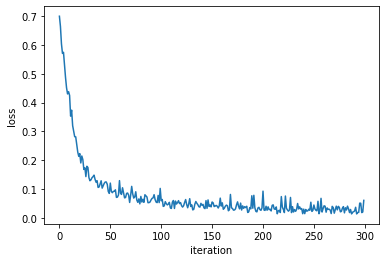

In [20]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()


## Question 3:Find the misclassified samples

<b>Identify the first four misclassified samples using the validation data:</b>

In [22]:
count = 0
max_num_of_items = 4  # first four mis-classified samples
validation_loader_batch_one = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1)

for i, (x_test, y_test) in enumerate(validation_loader_batch_one):
    # set model to eval
    model.eval()
    
    # make a prediction
    z = model(x_test)
    
    # find max
    _, yhat = torch.max(z.data, 1)
    
    # print mis-classified samples
    if yhat != y_test:
        print("Sample : {}; Expected Label: {}; Obtained Label: {}".format(str(i), str(y_test), str(yhat)))
        count += 1
        if count >= max_num_of_items:
            break
    # end if
# end for   

Sample : 22; Expected Label: tensor([1]); Obtained Label: tensor([0])
Sample : 101; Expected Label: tensor([0]); Obtained Label: tensor([1])
Sample : 182; Expected Label: tensor([1]); Obtained Label: tensor([0])
Sample : 213; Expected Label: tensor([0]); Obtained Label: tensor([1])


<a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/share-notebooks.html"> CLICK HERE </a> Click here to see how to share your notebook.

## About the Authors

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.

Copyright &copy; 2018 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.